## Analysis of The Leasing Market in Norway ##
By Jianling Li / December 2024

In [22]:
pip install xlrd==2.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import Series, DataFrame
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

### Part 1: Data Collection and preprocessing ###

### 1.1 Load Datasets ###

In [4]:
# Load the leasing dataset
leasing = pd.read_excel('andre-utlan.xls', sheet_name='Andre utlån - nytegning', skiprows=5)
leasing_filtered = leasing[(leasing['År'] >= 2015) & (leasing['År'] <= 2024)]
leasing_filtered

,År,Personbiler,Transportmidler,Busser,Kontor/data,Industr. Utstyr/maskiner,"Skip, fly, tog og trikk",Bygn./fast eiendom,Annet,Totale investeringer
0,2023,54347.6,7610.1,355.0,135.2,2342.1,560.5,1.700,5456.0,70808.200
1,2022,64709.0,6863.4,788.5,24.8,1870.0,325.5,2.800,6257.6,80841.600
2,2021,55059.9,6252.5,128.0,53.0,1647.0,442.8,33.300,6873.4,70489.900
3,2020,44509.8,5344.6,142.3,81.0,1457.2,284.9,16.000,6583.9,58419.700
4,2019,45615.2,6113.3,NaN,80.9,1235.0,588.3,2.500,6152.6,59787.800
5,2018,47709.0,6072.6,NaN,46.6,1219.1,368.8,222.500,5797.3,61435.900
6,2017,46398.2,5461.5,NaN,280.7,1216.1,308.7,124.300,5197.2,58986.700
7,2016,38599.3,5249.9,NaN,196.3,1082.2,624.0,0.972,3897.3,49649.972
8,2015,33964.3,4703.6,NaN,65.9,867.5,249.9,2.600,3812.2,43666.000


In [5]:
#Load leasing rate datasets
leasing_rate_business = pd.read_excel('Leasing_rate_business_20241205-215052.xlsx', skiprows=1)
leasing_rate_consum = pd.read_excel('Leasing_rate_consum_20241205-215209.xlsx', skiprows=1)
leasing_rate_total = pd.read_excel('Leasing_rate_total_20241205-211140.xlsx', skiprows=1)

In [9]:
leasing_rate_business.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,Renter på nye utlån
1,Andre nedbetalingslån,Ikke-finansielle foretak,2015M01,3.36
2,NaN,NaN,2015M02,3.07
3,NaN,NaN,2015M03,3.22
4,NaN,NaN,2015M04,3.37


In [11]:
leasing_rate_consum.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,Renter på nye utlån
1,Andre nedbetalingslån,Husholdninger,2015M01,5.8
2,NaN,NaN,2015M02,5.56
3,NaN,NaN,2015M03,5.67
4,NaN,NaN,2015M04,5.62


In [13]:
leasing_rate_total.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,Renter på nye utlån
1,Andre nedbetalingslån,Totalt,2015M01,3.57
2,NaN,NaN,2015M02,3.35
3,NaN,NaN,2015M03,3.5
4,NaN,NaN,2015M04,3.62


### 1.2 Clean and structure dataset for analyse ###

In [16]:
# Clean and structure leasing dataset
leasing_filtered.info()
leasing_filtered.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   År                        9 non-null      int64  
 1   Personbiler               9 non-null      float64
 2   Transportmidler           9 non-null      float64
 3   Busser                    4 non-null      float64
 4   Kontor/data               9 non-null      float64
 5   Industr. Utstyr/maskiner  9 non-null      float64
 6   Skip, fly, tog og trikk   9 non-null      float64
 7   Bygn./fast eiendom        9 non-null      float64
 8   Annet                     9 non-null      float64
 9   Totale investeringer      9 non-null      float64
dtypes: float64(9), int64(1)
memory usage: 792.0 bytes


,År,Personbiler,Transportmidler,Busser,Kontor/data,Industr. Utstyr/maskiner,"Skip, fly, tog og trikk",Bygn./fast eiendom,Annet,Totale investeringer
count,9.000000,9.000000,9.00000,4.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,2019.000000,47879.144444,5963.50000,353.450000,107.155556,1437.355556,417.044444,45.185778,5558.611111,61565.085778
std,2.738613,9186.176343,892.36971,308.049201,83.147927,452.561656,141.971724,77.435880,1097.116743,11284.589252
min,2015.000000,33964.300000,4703.60000,128.000000,24.800000,867.500000,249.900000,0.972000,3812.200000,43666.000000
25%,2017.000000,44509.800000,5344.60000,138.725000,53.000000,1216.100000,308.700000,2.500000,5197.200000,58419.700000
50%,2019.000000,46398.200000,6072.60000,248.650000,80.900000,1235.000000,368.800000,2.800000,5797.300000,59787.800000
75%,2021.000000,54347.600000,6252.50000,463.375000,135.200000,1647.000000,560.500000,33.300000,6257.600000,70489.900000
max,2023.000000,64709.000000,7610.10000,788.500000,280.700000,2342.100000,624.000000,222.500000,6873.400000,80841.600000


In [18]:
# Check for missing values 
print('Missing values before imputation:\n', leasing_filtered.isnull().sum())

Missing values before imputation:
 År                          0
Personbiler                 0
Transportmidler             0
Busser                      5
Kontor/data                 0
Industr. Utstyr/maskiner    0
Skip, fly, tog og trikk     0
Bygn./fast eiendom          0
Annet                       0
Totale investeringer        0
dtype: int64


In [20]:
# Options to handling missing values
# Option 1: Replace missing values with mean value
#missing_data = ['Busser']
#imputer = SimpleImputer(strategy='mean')
#leasing_filtered[missing_data] = imputer.fit_transform(leasing_filtered[missing_data])
#leasing_filtered['Busser'].fillna(leasing_filtered['Busser'].mean(), inplace=True)

# Option 2: Replace missing values with 0
#leasing_filtered['Busser'] = leasing_filtered['Busser'].fillna(0)

# Option 3: Replace missing value with average value in 2015 - 2023
# Calculate total sum of 'Busser' (ignoring NaN)
total_sum = leasing_filtered['Busser'].sum()

# Calculate average as total sum divided by total years (2015-2023)
average_value = total_sum / len(leasing_filtered['Busser'])

# Replace NaN values in 'Busser' with the calculated average
leasing_filtered.loc[:, 'Busser'] = leasing_filtered['Busser'].fillna(average_value)


# Check again to ensure all missing values have been filled
print('\nMissing values after imputation:\n', leasing_filtered.isnull().sum())

# Save the cleaned leasing dataset
leasing_filtered.to_csv('leasing_cleaned.csv', index=False)

leasing_cleaned = pd.read_csv('leasing_cleaned.csv')
leasing_cleaned


Missing values after imputation:
 År                          0
Personbiler                 0
Transportmidler             0
Busser                      0
Kontor/data                 0
Industr. Utstyr/maskiner    0
Skip, fly, tog og trikk     0
Bygn./fast eiendom          0
Annet                       0
Totale investeringer        0
dtype: int64


,År,Personbiler,Transportmidler,Busser,Kontor/data,Industr. Utstyr/maskiner,"Skip, fly, tog og trikk",Bygn./fast eiendom,Annet,Totale investeringer
0,2023,54347.6,7610.1,355.000000,135.2,2342.1,560.5,1.700,5456.0,70808.200
1,2022,64709.0,6863.4,788.500000,24.8,1870.0,325.5,2.800,6257.6,80841.600
2,2021,55059.9,6252.5,128.000000,53.0,1647.0,442.8,33.300,6873.4,70489.900
3,2020,44509.8,5344.6,142.300000,81.0,1457.2,284.9,16.000,6583.9,58419.700
4,2019,45615.2,6113.3,157.088889,80.9,1235.0,588.3,2.500,6152.6,59787.800
5,2018,47709.0,6072.6,157.088889,46.6,1219.1,368.8,222.500,5797.3,61435.900
6,2017,46398.2,5461.5,157.088889,280.7,1216.1,308.7,124.300,5197.2,58986.700
7,2016,38599.3,5249.9,157.088889,196.3,1082.2,624.0,0.972,3897.3,49649.972
8,2015,33964.3,4703.6,157.088889,65.9,867.5,249.9,2.600,3812.2,43666.000


In [22]:
# Clean and structure leasing datasets
leasing_rate_business = leasing_rate_business.iloc[2:].reset_index(drop=True)
leasing_rate_business.columns = ['Loan Type', 'Sector', 'Date', 'Leasing Rate']
leasing_rate_business = leasing_rate_business[['Date', 'Leasing Rate']]

leasing_rate_consum = leasing_rate_consum.iloc[2:].reset_index(drop=True)
leasing_rate_consum.columns = ['Loan Type', 'Sector', 'Date', 'Leasing Rate']
leasing_rate_consum = leasing_rate_consum[['Date', 'Leasing Rate']]


leasing_rate_total = leasing_rate_total.iloc[2:].reset_index(drop=True)
leasing_rate_total.columns = ['Loan Type', 'Sector', 'Date', 'Leasing Rate']
leasing_rate_total = leasing_rate_total[['Date', 'Leasing Rate']]

leasing_rate_business.head()

,Date,Leasing Rate
0,2015M02,3.07
1,2015M03,3.22
2,2015M04,3.37
3,2015M05,3.07
4,2015M06,3.17


In [24]:
leasing_rate_consum.head()

,Date,Leasing Rate
0,2015M02,5.56
1,2015M03,5.67
2,2015M04,5.62
3,2015M05,5.34
4,2015M06,5.17


In [26]:
leasing_rate_consum.head()

,Date,Leasing Rate
0,2015M02,5.56
1,2015M03,5.67
2,2015M04,5.62
3,2015M05,5.34
4,2015M06,5.17


In [28]:
# Drop rows where 'Date' is NaN
leasing_rate_business = leasing_rate_business.dropna(subset=['Date'])
leasing_rate_consum = leasing_rate_consum.dropna(subset=['Date'])
leasing_rate_total = leasing_rate_total.dropna(subset=['Date'])

# Convert 'Date' column to string
leasing_rate_business['Date'] = leasing_rate_business['Date'].astype(str)
leasing_rate_consum['Date'] = leasing_rate_consum['Date'].astype(str)
leasing_rate_total['Date'] = leasing_rate_total['Date'].astype(str)


# Extract the year from the 'Date' column
leasing_rate_business['År'] = leasing_rate_business['Date'].str[:4].astype(int)
leasing_rate_consum['År'] = leasing_rate_consum['Date'].str[:4].astype(int)
leasing_rate_total['År'] = leasing_rate_total['Date'].str[:4].astype(int)


# Convert 'Leasing Rate' to numeric
leasing_rate_business['Bedriftens Utlån Renter'] = pd.to_numeric(leasing_rate_business['Leasing Rate'], errors='coerce')
leasing_rate_consum['Forbrukes Utlån Renter'] = pd.to_numeric(leasing_rate_consum['Leasing Rate'], errors='coerce')
leasing_rate_total['Totalt Utlån Renter'] = pd.to_numeric(leasing_rate_total['Leasing Rate'], errors='coerce')

# Group by 'Year' and calculate the mean leasing rate
business_yearly_rate = leasing_rate_business.groupby('År', as_index=False)['Bedriftens Utlån Renter'].mean()
consum_yearly_rate = leasing_rate_consum.groupby('År', as_index=False)['Forbrukes Utlån Renter'].mean()
total_yearly_rate = leasing_rate_total.groupby('År', as_index=False)['Totalt Utlån Renter'].mean()

# Rename the column for clarity
#business_yearly_rate.rename(columns={'Bedriftens Utlån Renter': 'Business Yearly Leasing Rate'}, inplace=True)
#consum_yearly_rate.rename(columns={'Forbrukes Utlån Renter': 'Business Yearly Leasing Rate'}, inplace=True)
#total_yearly_rate.rename(columns={'Annet Utlån Renter': 'Business Yearly Leasing Rate'}, inplace=True)

business_yearly_rate

,År,Bedriftens Utlån Renter
0,2015,2.973636
1,2016,2.925000
2,2017,2.852500
3,2018,3.003333
4,2019,3.453333
5,2020,2.743333
6,2021,2.366667
7,2022,3.778333
8,2023,5.820000
9,2024,6.597000


In [30]:
consum_yearly_rate

,År,Forbrukes Utlån Renter
0,2015,5.430000
1,2016,6.493333
2,2017,5.848333
3,2018,4.520833
4,2019,5.025833
5,2020,4.150000
6,2021,3.840833
7,2022,4.871667
8,2023,6.658333
9,2024,7.255000


In [32]:
total_yearly_rate

,År,Totalt Utlån Renter
0,2015,3.520141
1,2016,3.525833
2,2017,3.398056
3,2018,3.157917
4,2019,3.609583
5,2020,2.912778
6,2021,2.568611
7,2022,3.799722
8,2023,5.824444
9,2024,6.546000


### 1.3 Merge the datasets to analysing format ###

In [34]:
# Merge leasing_cleaned with business_yearly_rate
merged_data = leasing_cleaned.merge(business_yearly_rate, on='År', how='left')

# Merge with consum_yearly_rate
merged_data = merged_data.merge(consum_yearly_rate, on='År', how='left')

# Merge with total_yearly_rate
merged_data = merged_data.merge(total_yearly_rate, on='År', how='left')

# Select relevant columns for analysis
analysis_data = merged_data[['År', 'Personbiler', 'Transportmidler', 'Busser', 'Kontor/data', 'Industr. Utstyr/maskiner', 'Skip, fly, tog og trikk',
                             'Bygn./fast eiendom', 'Annet', 'Bedriftens Utlån Renter', 'Forbrukes Utlån Renter', 'Totalt Utlån Renter', 'Totale investeringer']]


# Save to a CSV file
analysis_data.to_csv('merged_leasing_analysis.csv', index=False)
analysis_data

,År,Personbiler,Transportmidler,Busser,Kontor/data,Industr. Utstyr/maskiner,"Skip, fly, tog og trikk",Bygn./fast eiendom,Annet,Bedriftens Utlån Renter,Forbrukes Utlån Renter,Totalt Utlån Renter,Totale investeringer
0,2023,54347.6,7610.1,355.000000,135.2,2342.1,560.5,1.700,5456.0,5.820000,6.658333,5.824444,70808.200
1,2022,64709.0,6863.4,788.500000,24.8,1870.0,325.5,2.800,6257.6,3.778333,4.871667,3.799722,80841.600
2,2021,55059.9,6252.5,128.000000,53.0,1647.0,442.8,33.300,6873.4,2.366667,3.840833,2.568611,70489.900
3,2020,44509.8,5344.6,142.300000,81.0,1457.2,284.9,16.000,6583.9,2.743333,4.150000,2.912778,58419.700
4,2019,45615.2,6113.3,157.088889,80.9,1235.0,588.3,2.500,6152.6,3.453333,5.025833,3.609583,59787.800
5,2018,47709.0,6072.6,157.088889,46.6,1219.1,368.8,222.500,5797.3,3.003333,4.520833,3.157917,61435.900
6,2017,46398.2,5461.5,157.088889,280.7,1216.1,308.7,124.300,5197.2,2.852500,5.848333,3.398056,58986.700
7,2016,38599.3,5249.9,157.088889,196.3,1082.2,624.0,0.972,3897.3,2.925000,6.493333,3.525833,49649.972
8,2015,33964.3,4703.6,157.088889,65.9,867.5,249.9,2.600,3812.2,2.973636,5.430000,3.520141,43666.000


### Part 2: Exploratory analysis ###

### 2.1 Analyze the development in leasing for various equipment categories over time ###

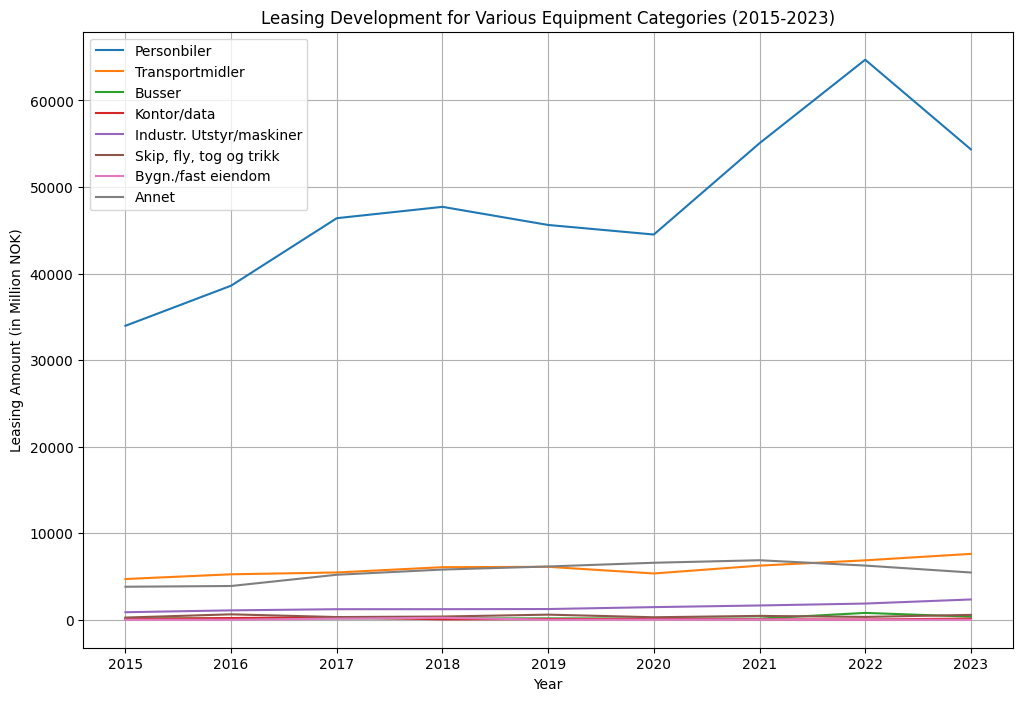

In [36]:
# List of equipment categories to analyze
#equipment_categories = ['Personbiler', 'Transportmidler', 'Busser', 'Kontor/data', 
                        #'Industr. Utstyr/maskiner', 'Skip, fly, tog og trikk', 'Bygn./fast eiendom', 'Annet']

# Define the categories
categories = ['Personbiler', 'Transportmidler', 'Busser', 'Kontor/data', 
              'Industr. Utstyr/maskiner', 'Skip, fly, tog og trikk', 
              'Bygn./fast eiendom', 'Annet']

# Calculate year-over-year growth rates for each category
growth_rates = analysis_data[categories].pct_change() * 100  # Percentage growth

# Add 'År' back to growth_rates DataFrame
growth_rates['År'] = analysis_data['År']

# Plot trends for each equipment category
plt.figure(figsize=(12, 8))
for category in categories:
    plt.plot(analysis_data['År'], analysis_data[category], label=category)

# Add labels and legend
plt.title('Leasing Development for Various Equipment Categories (2015-2023)')
plt.xlabel('Year')
plt.ylabel('Leasing Amount (in Million NOK)')
plt.legend()
plt.grid(True)
plt.show()


### 2.2 Identify and visualize trends and seasonal variations ###

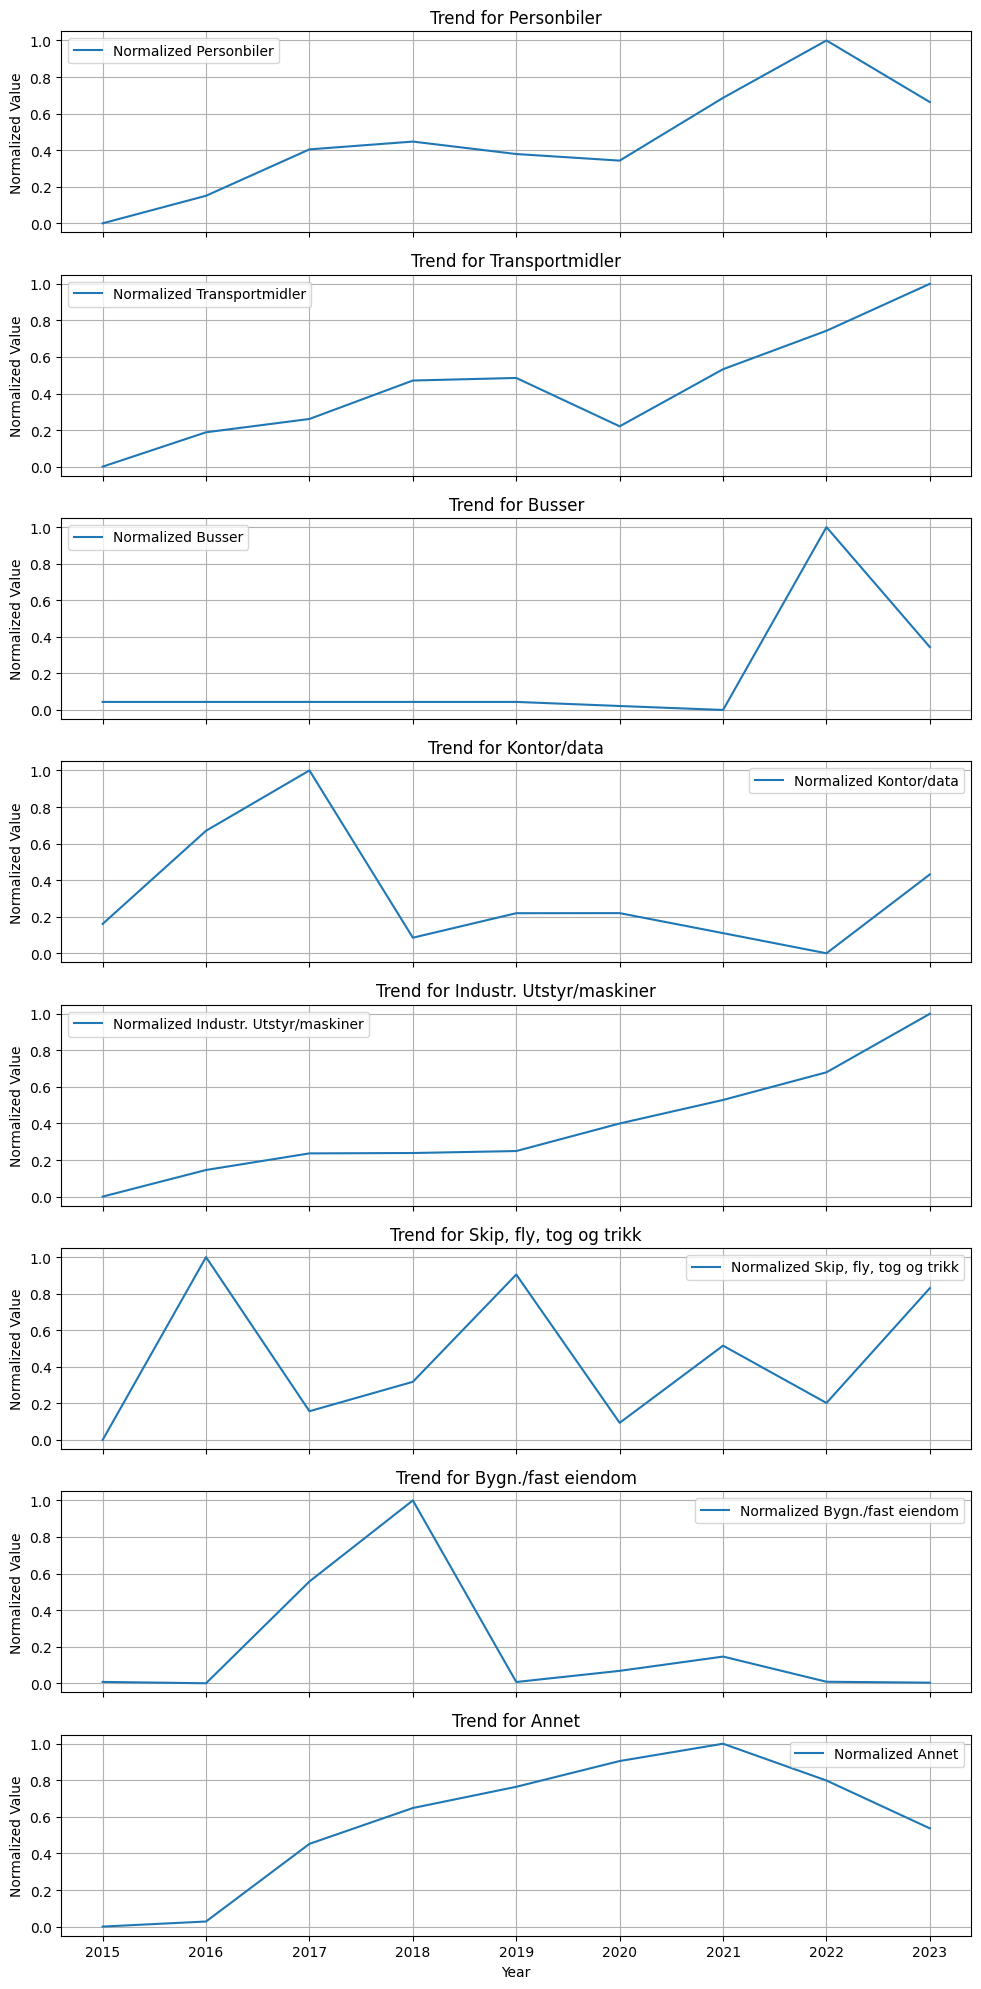

In [38]:
# Normalize data for trend comparison
normalized_data = analysis_data[categories].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Add 'År' back to normalized data
normalized_data['År'] = analysis_data['År']

# Create subplots for each equipment category
fig, axes = plt.subplots(len(categories), 1, figsize=(10, 20), sharex=True)

for i, category in enumerate(categories):
    axes[i].plot(normalized_data['År'], normalized_data[category], label=f'Normalized {category}')
    axes[i].set_title(f'Trend for {category}')
    axes[i].set_ylabel('Normalized Value')
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel('Year')
plt.tight_layout()
plt.show()

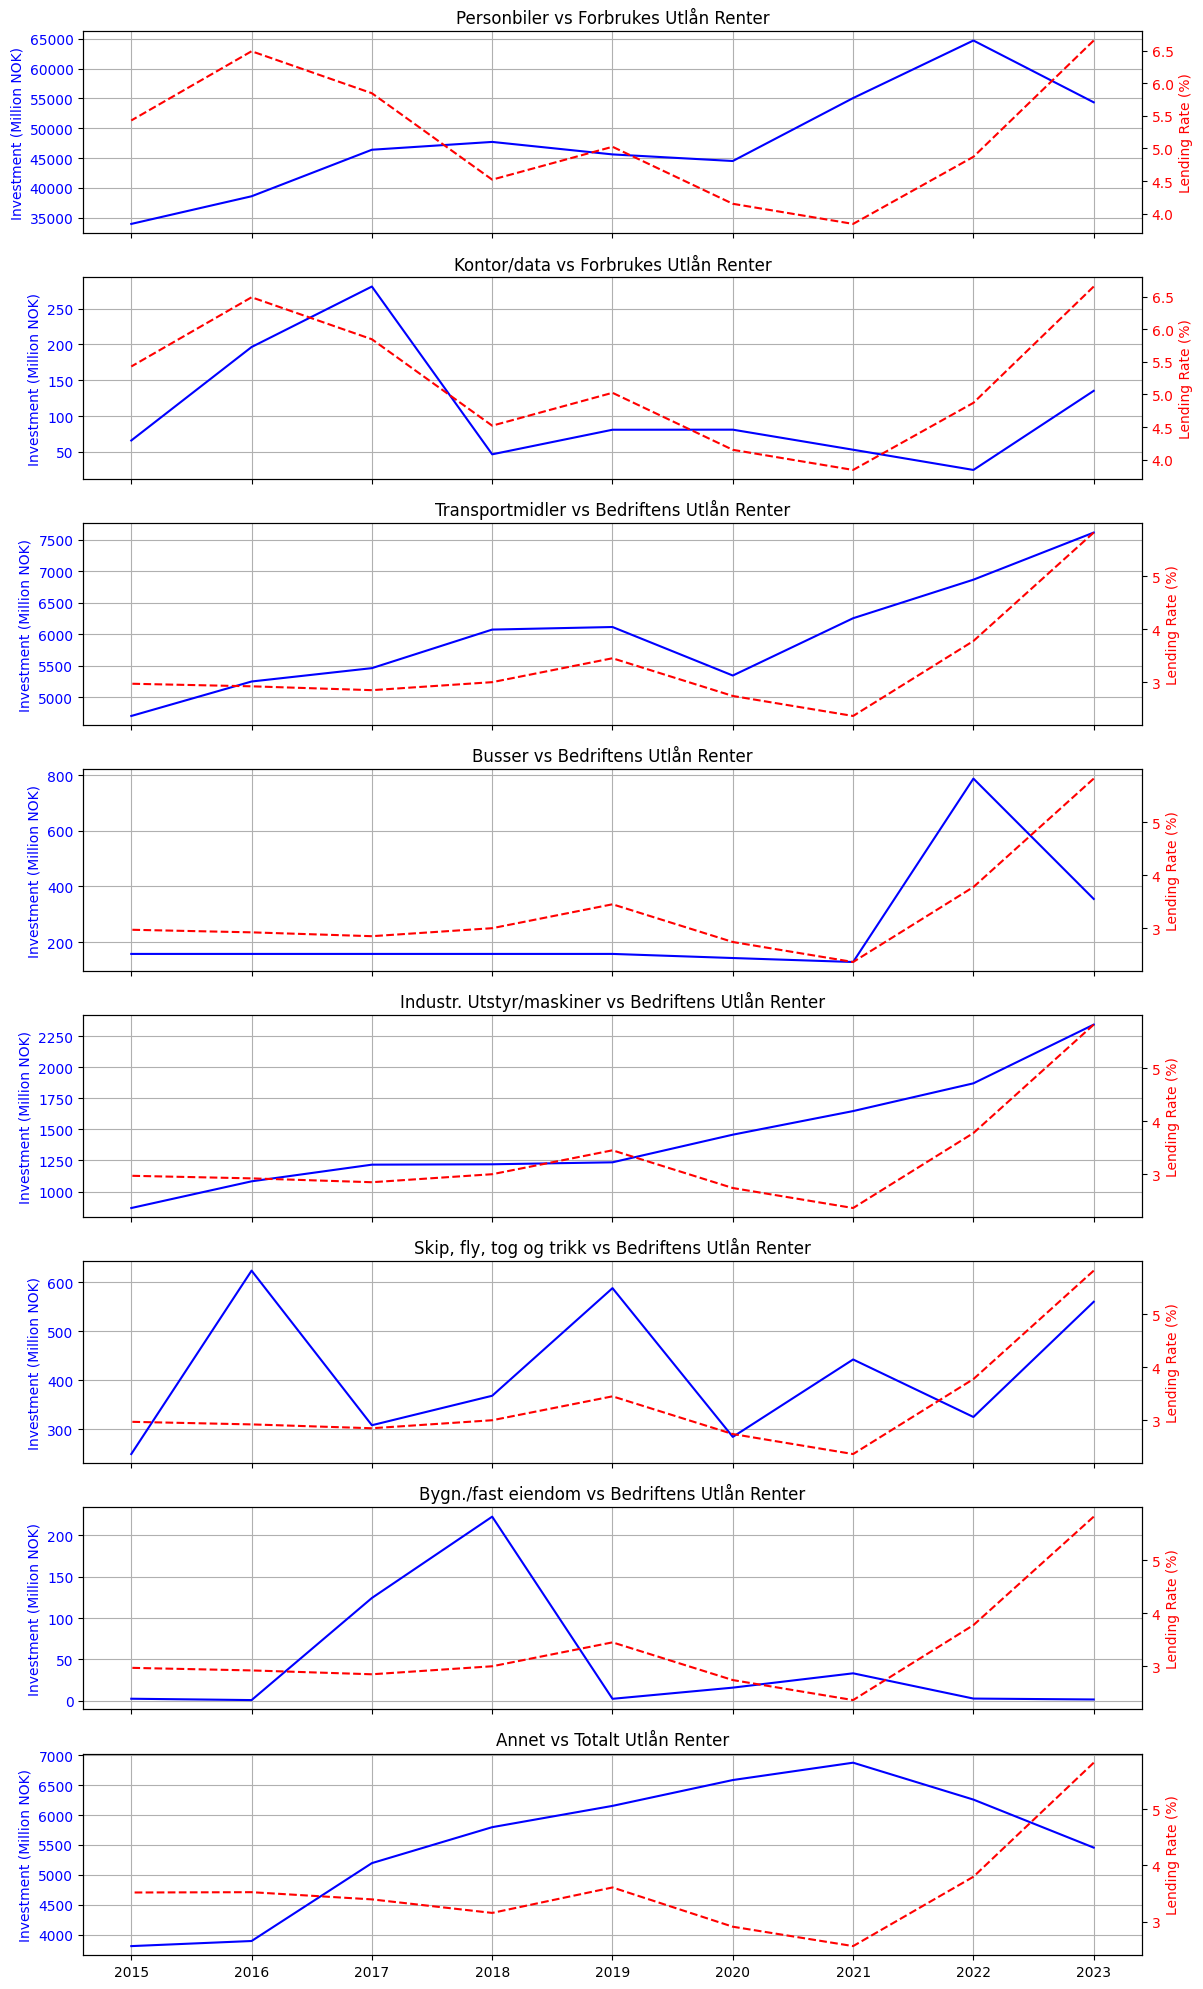

In [40]:
# Define category-to-rate mapping
category_to_rate = {
    'Personbiler': 'Forbrukes Utlån Renter',
    'Kontor/data': 'Forbrukes Utlån Renter',
    'Transportmidler': 'Bedriftens Utlån Renter',
    'Busser': 'Bedriftens Utlån Renter',
    'Industr. Utstyr/maskiner': 'Bedriftens Utlån Renter',
    'Skip, fly, tog og trikk': 'Bedriftens Utlån Renter',
    'Bygn./fast eiendom': 'Bedriftens Utlån Renter',
    'Annet': 'Totalt Utlån Renter'
}

# Create subplots for each category
fig, axes = plt.subplots(len(category_to_rate), 1, figsize=(12, 20), sharex=True)

for i, (category, rate) in enumerate(category_to_rate.items()):
    ax = axes[i]
    # Plot the category on the primary y-axis
    ax.plot(analysis_data['År'], leasing_cleaned[category], label=f'{category} (Investment)', color='blue')
    ax.set_ylabel('Investment (Million NOK)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot the corresponding rate on the secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(analysis_data['År'], analysis_data[rate], label=f'{rate} (Rate)', color='red', linestyle='--')
    ax2.set_ylabel('Lending Rate (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add titles and legends
    ax.set_title(f'{category} vs {rate}')
    ax.grid(True)

# Add common labels
plt.xlabel('Year')
plt.tight_layout()
plt.show()

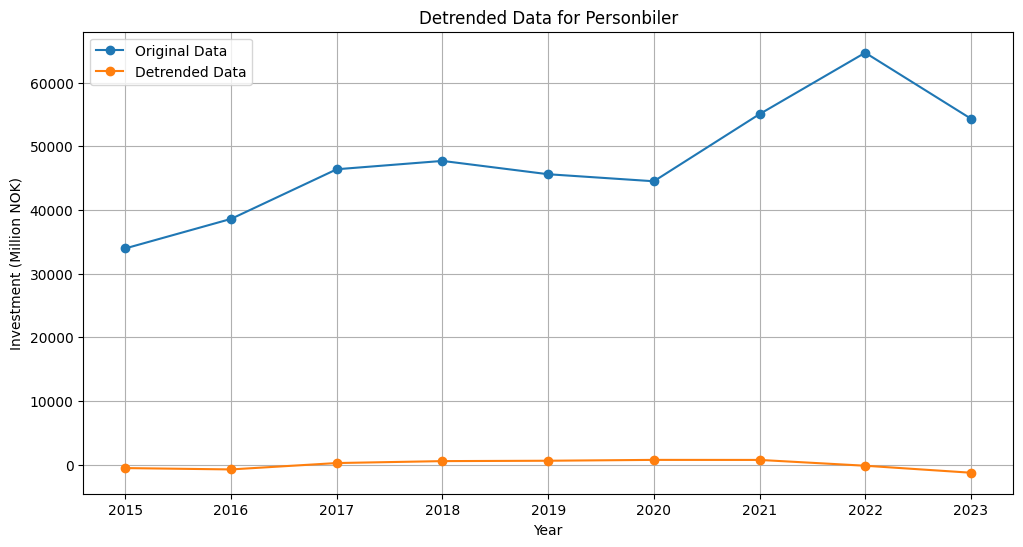

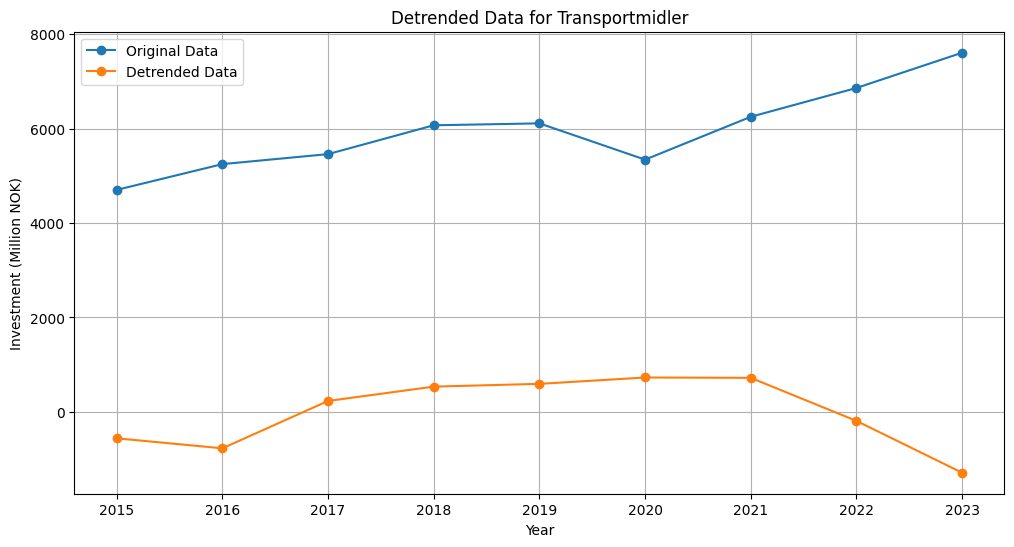

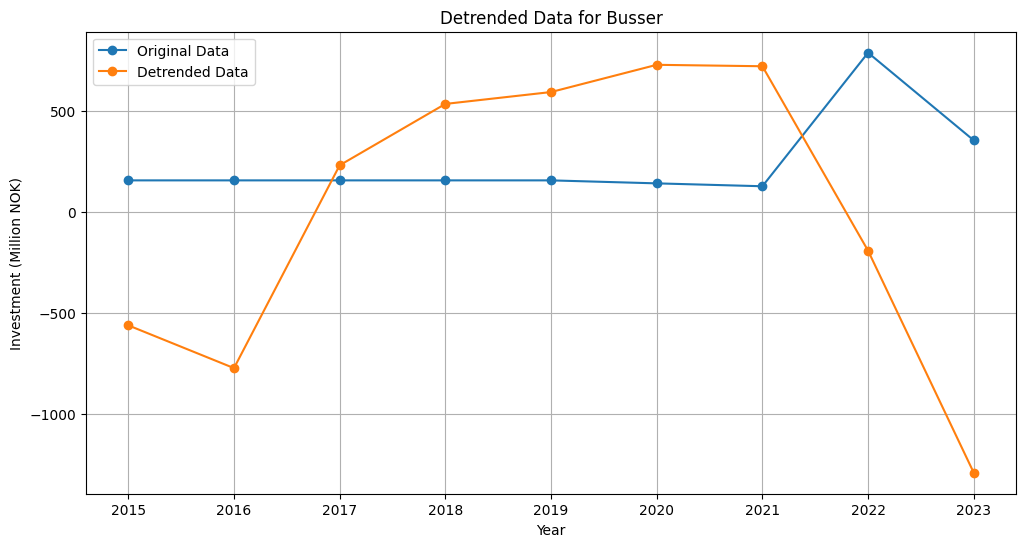

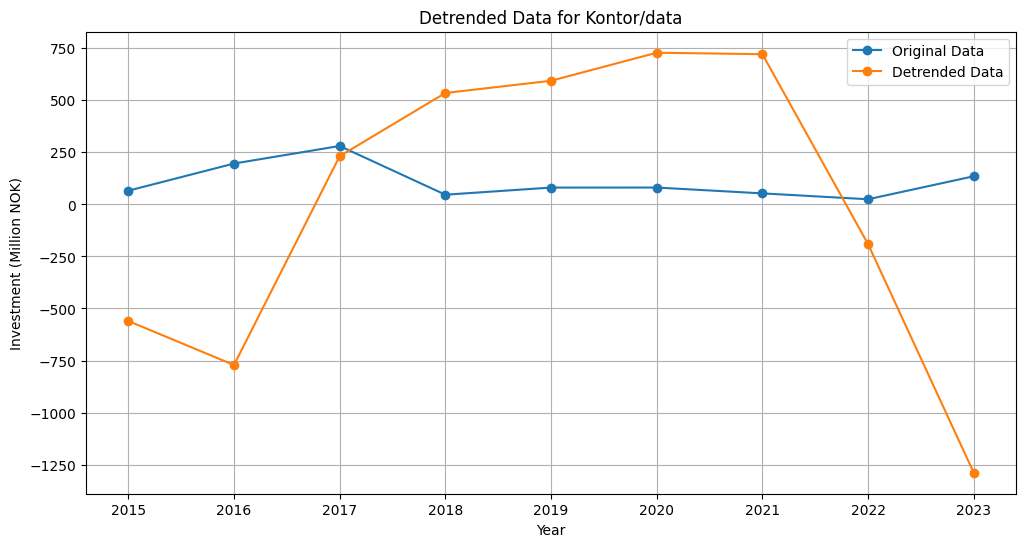

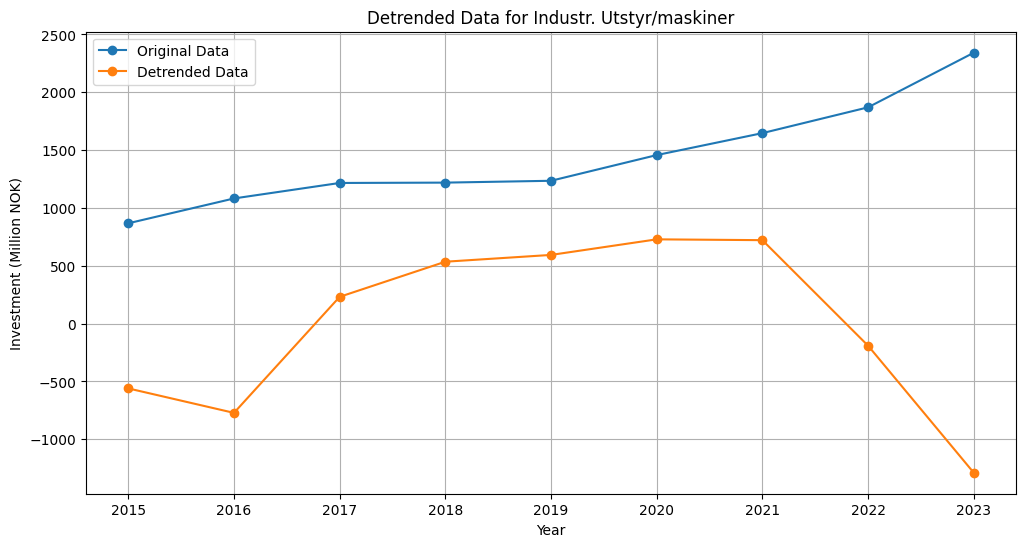

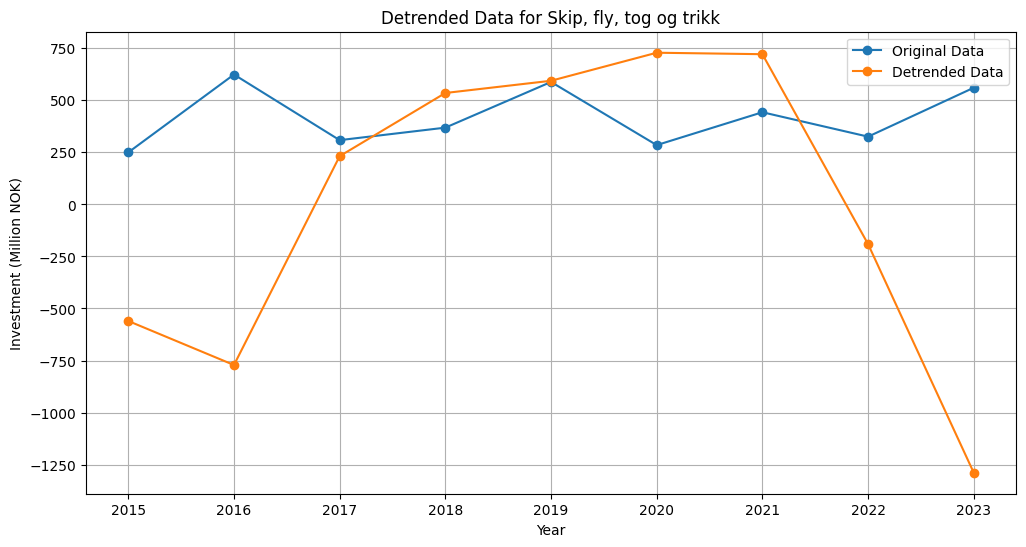

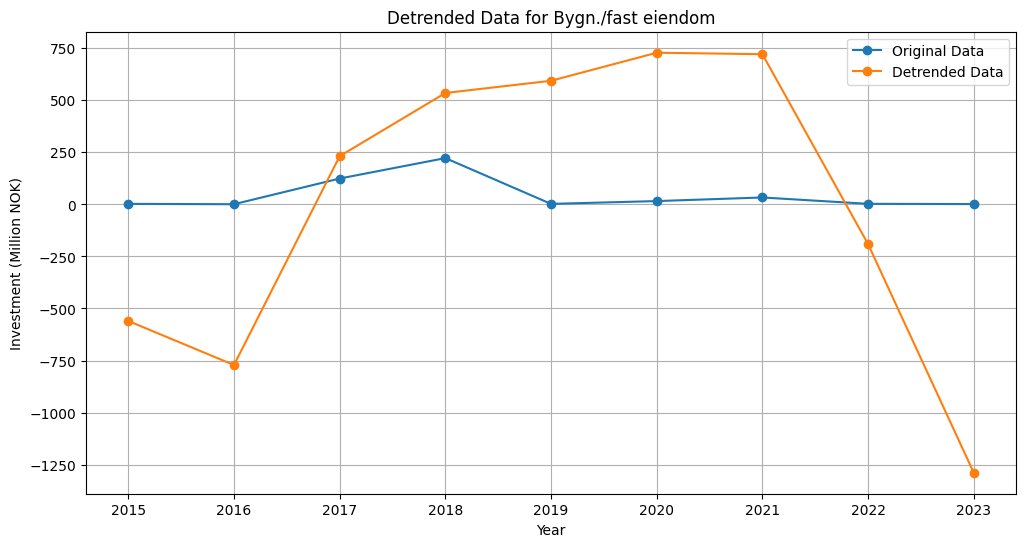

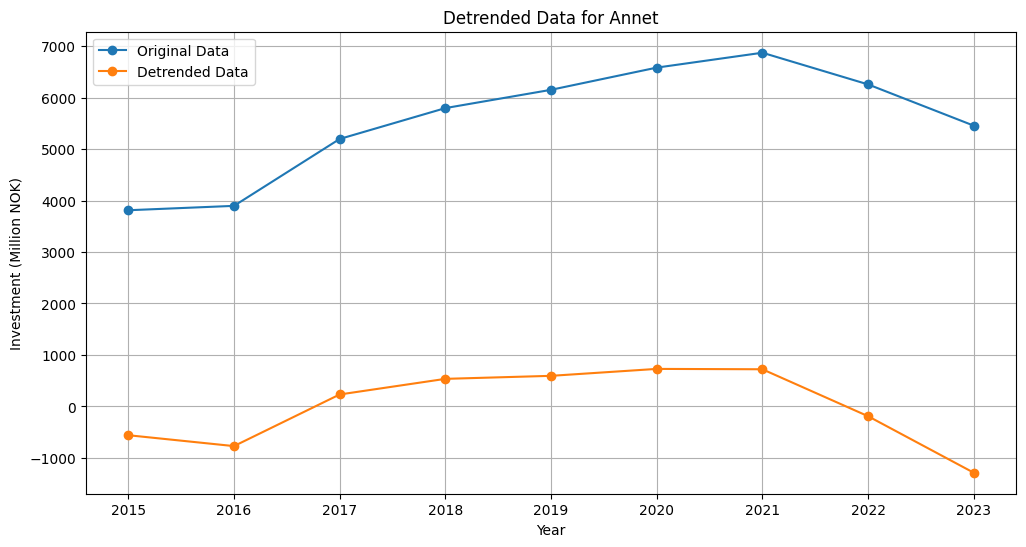

In [42]:
# approximating seasonal variations

# Detrend the data
detrended_data = detrend(analysis_data[category].dropna())

for i, category in enumerate(categories):
    # Plot the original and detrended data
    plt.figure(figsize=(12, 6))
    plt.plot(analysis_data['År'], analysis_data[category], label='Original Data', marker='o')
    plt.plot(analysis_data['År'], detrended_data, label='Detrended Data', marker='o')
    plt.title(f'Detrended Data for {category}')
    plt.xlabel('Year')
    plt.ylabel('Investment (Million NOK)')
    plt.legend()
    plt.grid(True)
    plt.show()


### 2.3 Compare growth rates between different categories ####

/var/folders/k1/3q3lwl6x7rd1jdzn9_z1wg9c0000gn/T/ipykernel_20450/71051374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['Total Growth Rate'] = analysis_data['Totale investeringer'].pct_change()
/var/folders/k1/3q3lwl6x7rd1jdzn9_z1wg9c0000gn/T/ipykernel_20450/71051374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data[f'{category} Growth Rate'] = analysis_data[category].pct_change()
/var/folders/k1/3q3lwl6x7rd1jdzn9_z1wg9c0000gn/T/ipykernel_20450/71051374.py:7: SettingWithC

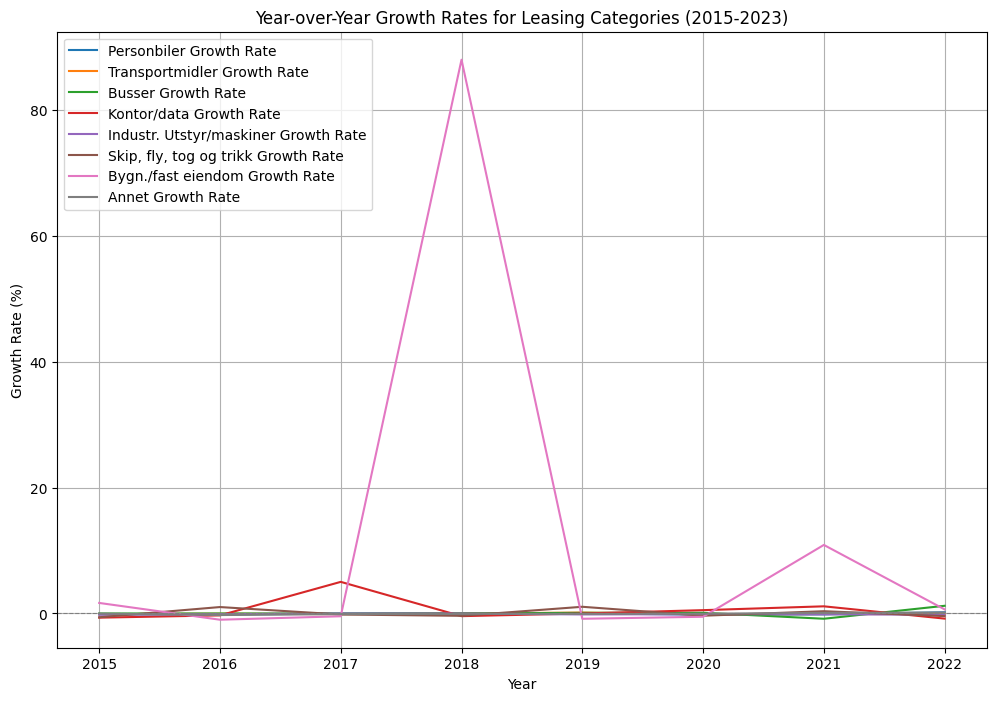

In [44]:
analysis_data['Total Growth Rate'] = analysis_data['Totale investeringer'].pct_change() 

# Plot the growth rates
plt.figure(figsize=(12, 8))  # Set figure size

for category in categories: #['Personbiler', 'Transportmidler', 'Busser', 'Kontor/data', 'Industr. Utstyr/maskiner', 'Skip, fly, tog og trikk', 'Bygn./fast eiendom', 'Annet']:
    analysis_data[f'{category} Growth Rate'] = analysis_data[category].pct_change() 
    plt.plot(analysis_data['År'], analysis_data[f'{category} Growth Rate'], label=f'{category} Growth Rate')

# Add labels, legend, and title
plt.title('Year-over-Year Growth Rates for Leasing Categories (2015-2023)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Highlight 0% growth
plt.legend(loc='upper left')  # Adjust legend position if needed
plt.grid(True)
plt.show()

/var/folders/k1/3q3lwl6x7rd1jdzn9_z1wg9c0000gn/T/ipykernel_20450/4165604497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['Total Growth Rate'] = analysis_data['Totale investeringer'].pct_change()
/var/folders/k1/3q3lwl6x7rd1jdzn9_z1wg9c0000gn/T/ipykernel_20450/4165604497.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data[f'{category} Growth Rate'] = analysis_data[category].pct_change()


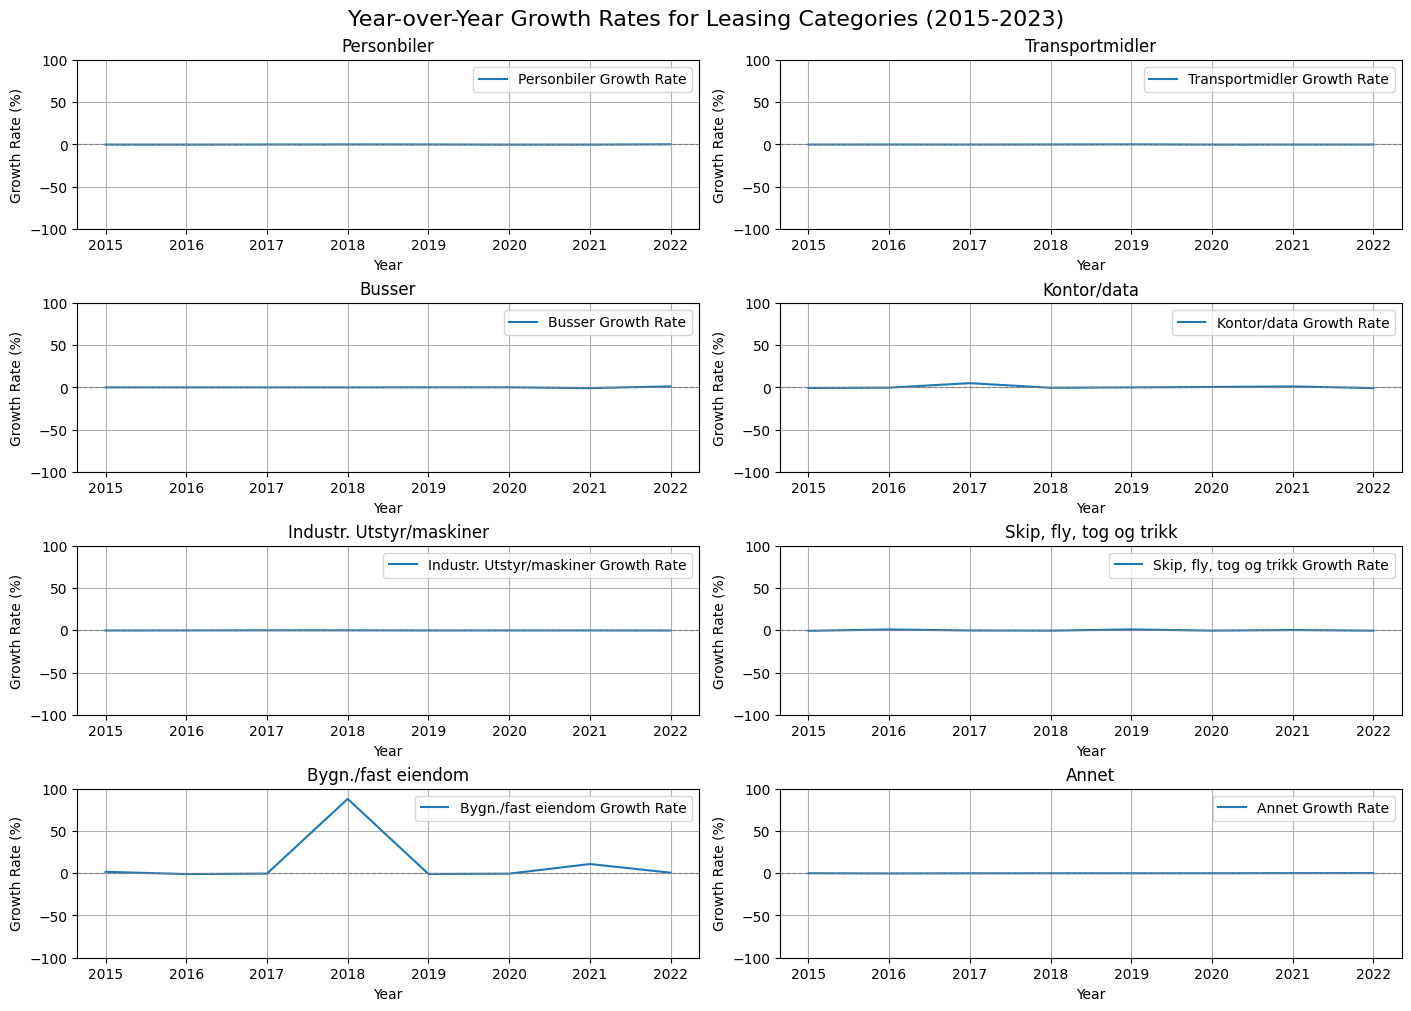

In [46]:
# Define the categories
categories = ['Personbiler', 'Transportmidler', 'Busser', 'Kontor/data', 
              'Industr. Utstyr/maskiner', 'Skip, fly, tog og trikk', 
              'Bygn./fast eiendom', 'Annet']

analysis_data['Total Growth Rate'] = analysis_data['Totale investeringer'].pct_change()
for category in categories: #['Personbiler', 'Transportmidler', 'Busser', 'Kontor/data', 'Industr. Utstyr/maskiner', 'Skip, fly, tog og trikk', 'Bygn./fast eiendom', 'Annet']:
    analysis_data[f'{category} Growth Rate'] = analysis_data[category].pct_change()


# Set up the figure and subplots
num_categories = len(categories)
cols = 2  # Number of columns in the grid
rows = (num_categories + cols - 1) // cols  # Calculate rows dynamically

fig, axes = plt.subplots(rows, cols, figsize=(14, 10), constrained_layout=True)

# Flatten the axes array for easier iteration (handles single row/column cases)
axes = axes.flatten()

# Define uniform y-axis range
y_min, y_max = -100, 100  # Adjust limits based on data range

# Plot each category in its own subplot
for i, category in enumerate(categories):
    ax = axes[i]
    ax.plot(analysis_data['År'], analysis_data[f'{category} Growth Rate'], label=f'{category} Growth Rate')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Highlight 0% growth
    ax.set_title(category)
    ax.set_xlabel('Year')
    ax.set_ylabel('Growth Rate (%)')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(y_min, y_max)  # Apply the uniform y-axis range

# Turn off any empty subplots (in case the grid has extra spaces)
for j in range(len(categories), len(axes)):
    fig.delaxes(axes[j])

# Add a main title for the entire figure
fig.suptitle('Year-over-Year Growth Rates for Leasing Categories (2015-2023)', fontsize=16)

# Show the plot
plt.show()

### 2.4 Formulate at least three hypotheses based on observed patterns ###
(Refer to report)

### Part 3: Correlation analysis ###

### 3.1 Investigate the correlation between interest rates and office/computer equipment leasing ###

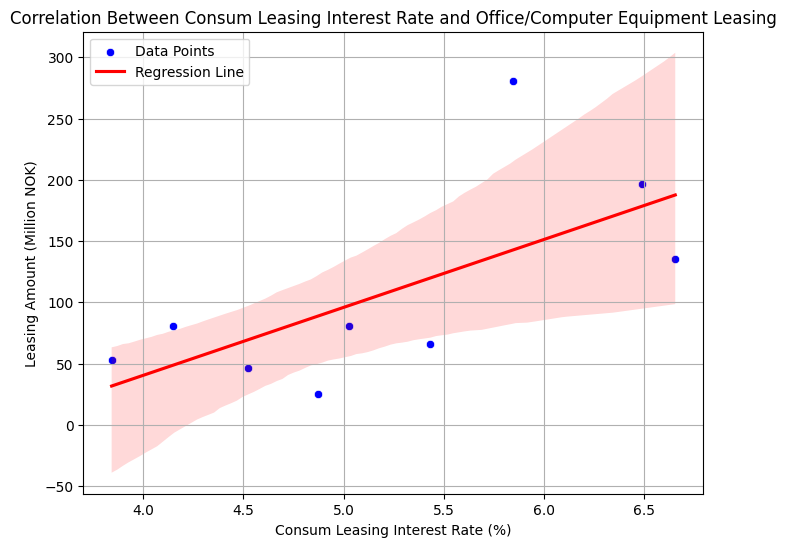

In [48]:
analysis_data = pd.read_csv('merged_leasing_analysis.csv')

# Select the relevant columns
consum_rate = analysis_data['Forbrukes Utlån Renter']
office_leasing = analysis_data['Kontor/data']

# Visualize the relationship 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=consum_rate, y=office_leasing, color='blue', label='Data Points')
sns.regplot(x=consum_rate, y=office_leasing, scatter=False, color='red', label='Regression Line')
plt.title('Correlation Between Consum Leasing Interest Rate and Office/Computer Equipment Leasing')
plt.xlabel('Consum Leasing Interest Rate (%)')
plt.ylabel('Leasing Amount (Million NOK)')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Perform statistical tests to validate the findings ###

In [50]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(consum_rate, office_leasing)
print(f'Pearson Correlation Coefficient: {correlation_coefficient: .2f}')
print(f'P-Value: {p_value: .4f}')

# Perform Linear Regression
X = consum_rate.values.reshape(-1, 1)
y = office_leasing.values

model = LinearRegression()
model.fit(X, y)

# Regression results
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)

print(f"Linear Regression Equation: y = {slope:.2f}x + {intercept:.2f}")
print(f"R-Squared: {r_squared:.2f}")

Pearson Correlation Coefficient:  0.66
P-Value:  0.0539
Linear Regression Equation: y = 55.36x + -180.97
R-Squared: 0.43


### 3.3 Visualize the connections ###

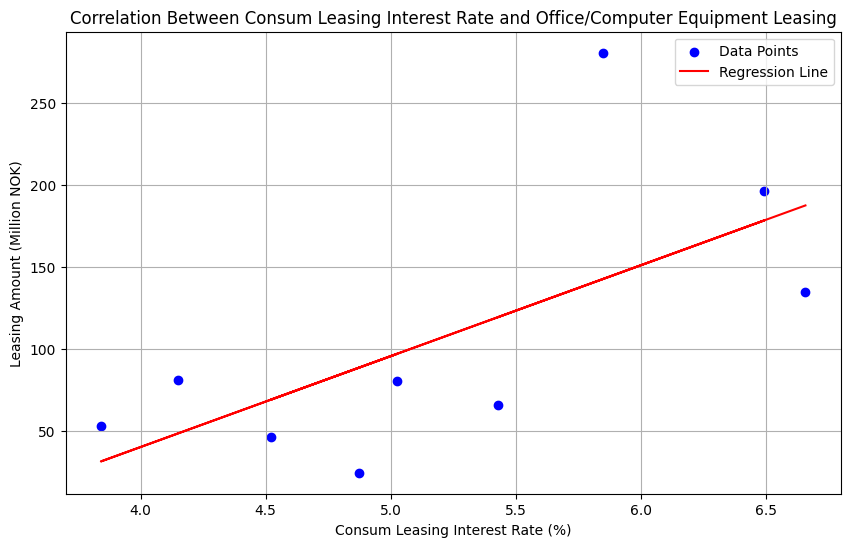

In [52]:
# Scatter plot of interest rates vs. leasing
plt.figure(figsize=(10, 6))
plt.scatter(analysis_data['Forbrukes Utlån Renter'], analysis_data['Kontor/data'], color='blue', label='Data Points')

# Regression line
x = analysis_data['Forbrukes Utlån Renter']
y = analysis_data['Kontor/data']
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')

# Labels, title, legend
plt.title('Correlation Between Consum Leasing Interest Rate and Office/Computer Equipment Leasing')
plt.xlabel('Consum Leasing Interest Rate (%)')
plt.ylabel('Leasing Amount (Million NOK)')
plt.legend()
plt.grid(True)
plt.show()

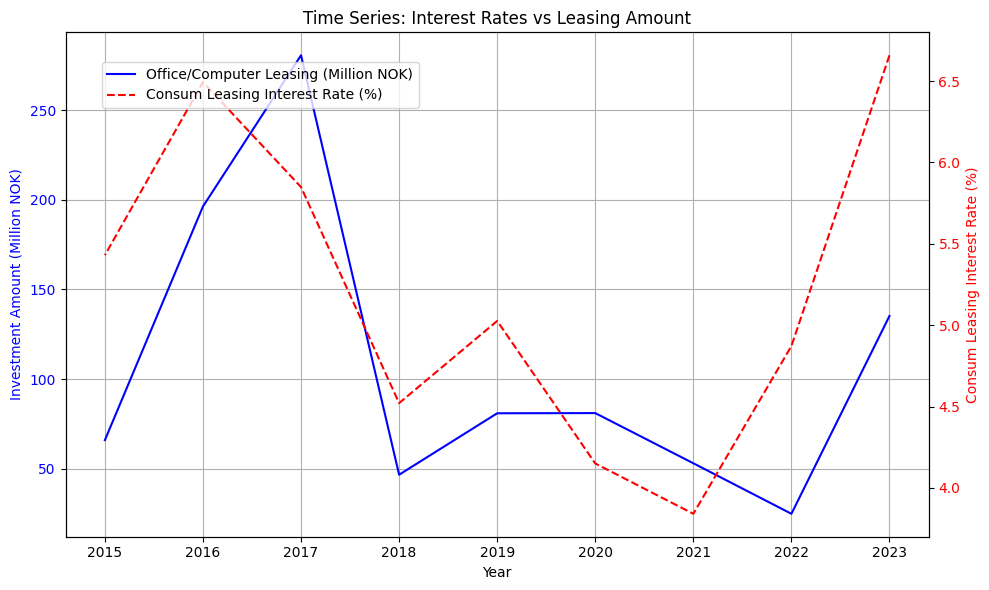

In [56]:
# Plot time series of interest rates and leasing
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Office/Computer Leasing (Investment) on the primary y-axis (left)
ax1.plot(
    analysis_data['År'], 
    analysis_data['Kontor/data'], 
    label='Office/Computer Leasing (Million NOK)', 
    color='blue'
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Investment Amount (Million NOK)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a twin y-axis for the Consum Leasing Interest Rate
ax2 = ax1.twinx()
ax2.plot(
    analysis_data['År'], 
    analysis_data['Forbrukes Utlån Renter'], 
    label='Consum Leasing Interest Rate (%)', 
    color='red', 
    linestyle='--'
)
ax2.set_ylabel('Consum Leasing Interest Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
plt.title('Time Series: Interest Rates vs Leasing Amount')

# Add legends (adjust for clarity)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.tight_layout()
plt.show()

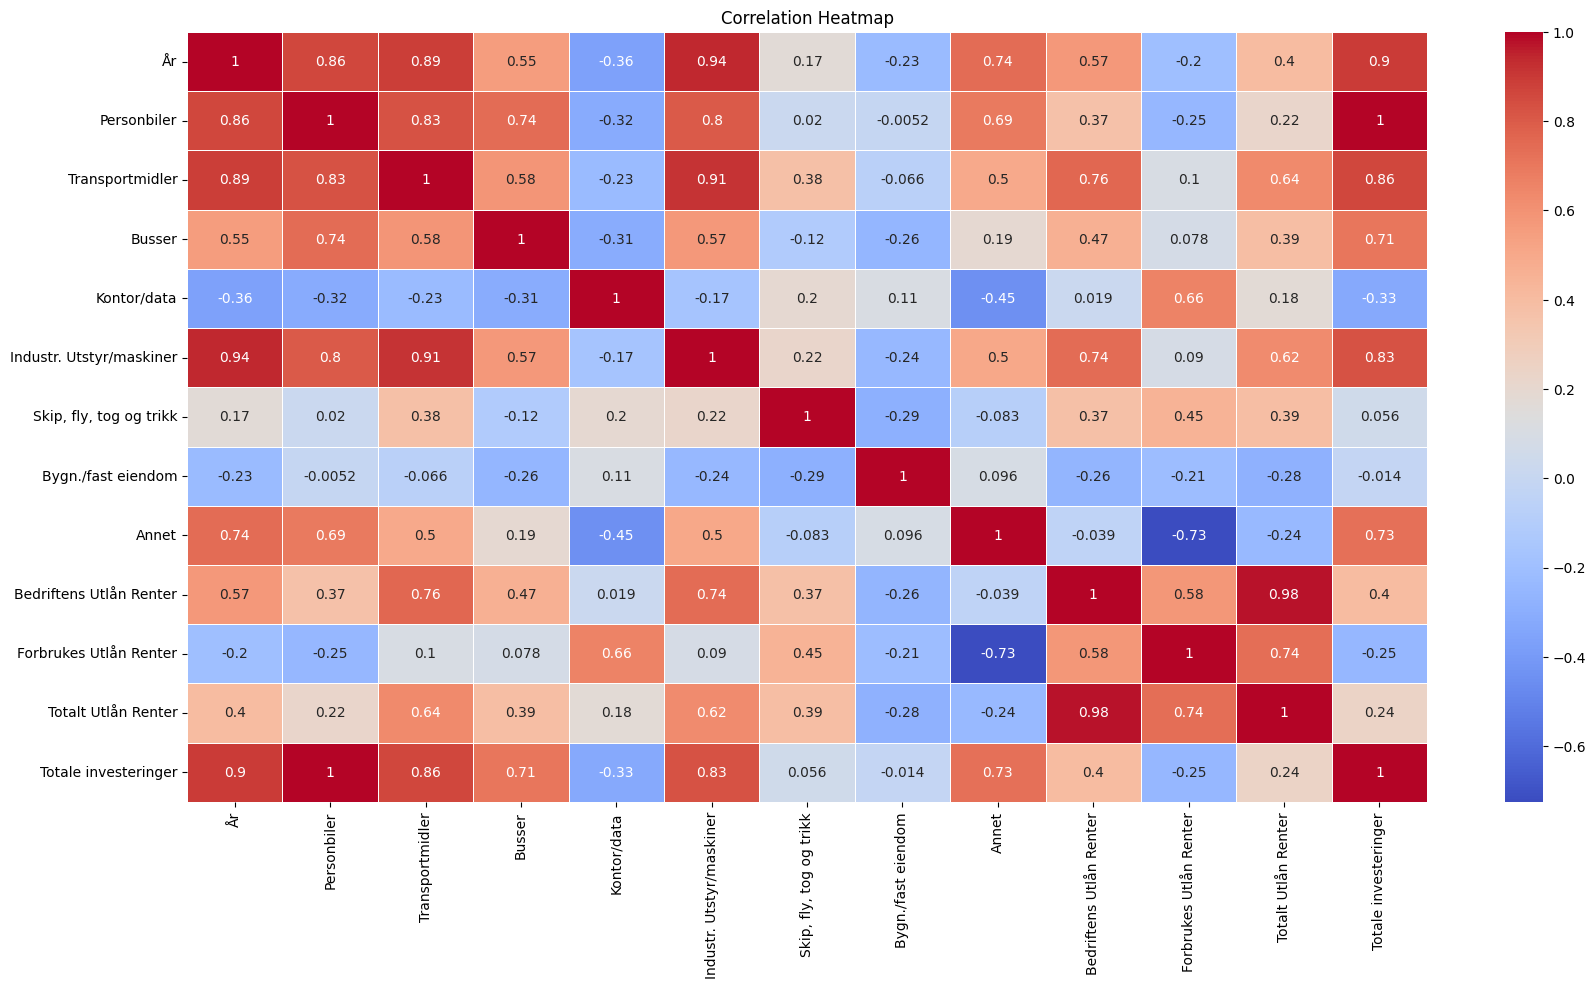

In [58]:
# Correlation Heatmap
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.heatmap(analysis_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### 3.4 Unsupervised Learning: Principle Component Analysis (PCA) ###

For the dataset without target variables, like this leasing dataset, unsupervised learning method PCA model is recommanded. All the feature correlations can be intuitively displayed in the vectors directions and the distance between the features.

Text(0.5, 1.0, 'PCA Visualization with Top 20 Feature Loadings')

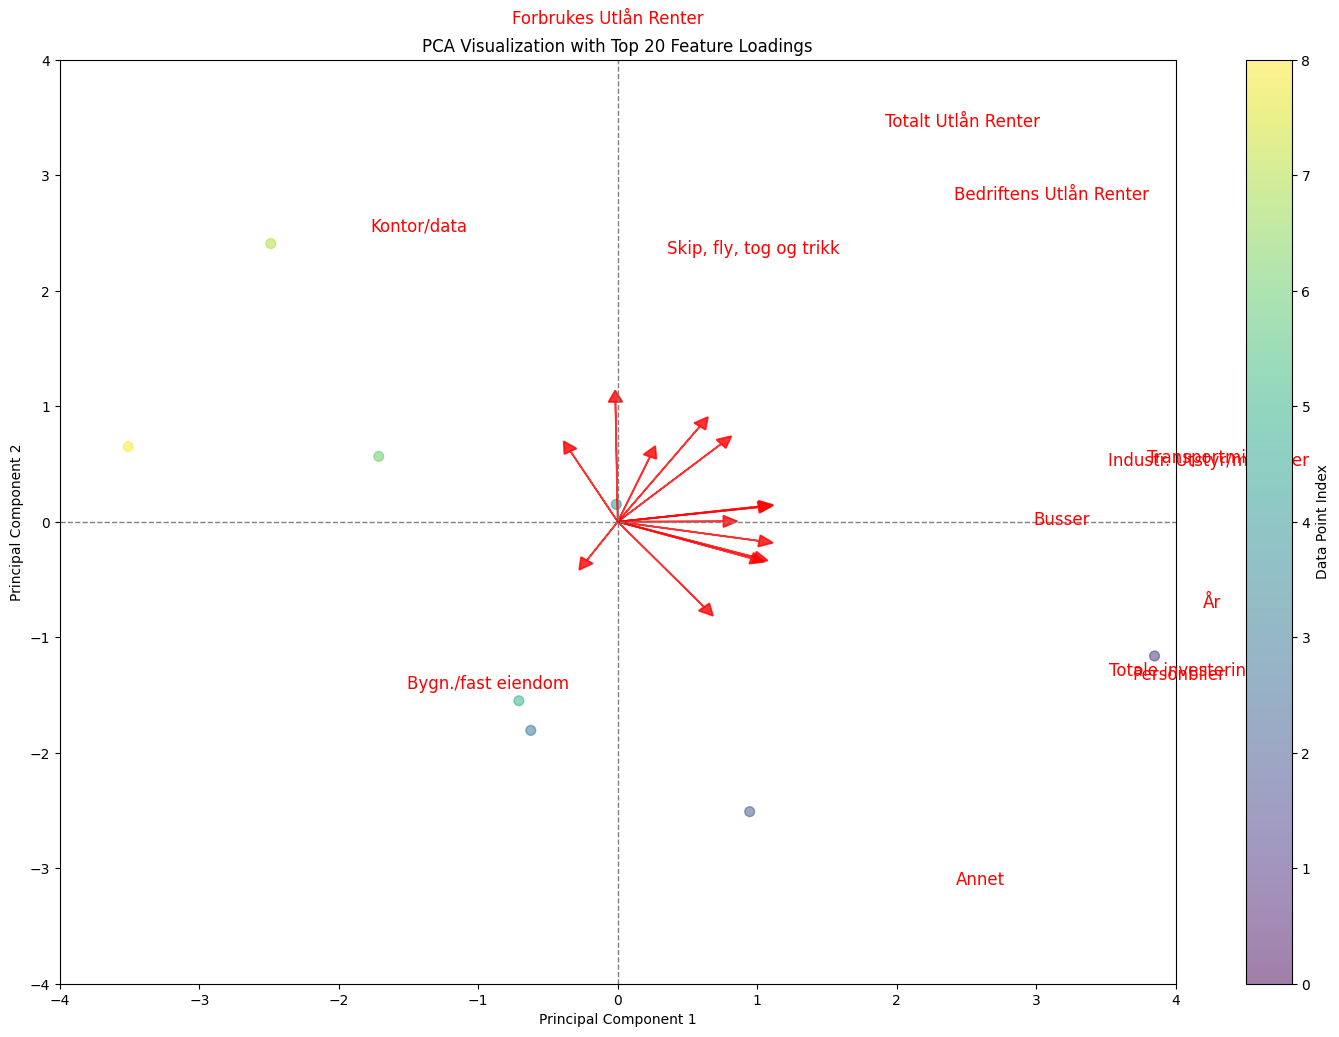

In [68]:
# Standardize the features
X = pd.DataFrame(scale(analysis_data), index=analysis_data.index, columns=analysis_data.columns)

# Perform PCA
pca = PCA(n_components=2)
analysis_data_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2'], index=X.index)

# Loading for the top 20 features
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=analysis_data.columns, columns=['PC1_load', 'PC2_load'])

# plot
fig, ax1 = plt.subplots(figsize=(18,12))

ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

# Colorful scatter plot of the data points
scatter = ax1.scatter(analysis_data_plot['PC1'], analysis_data_plot['PC2'], c=np.arange(len(analysis_data_plot)), cmap='viridis', alpha=0.5, s=50)
plt.colorbar(scatter, ax=ax1, label='Data Point Index') 

# Limit the number of labels to top features for readability
top_features = pca_loadings.abs().sum(axis=1).nlargest(20).index
for i in top_features:
    ax1.arrow(0, 0, pca_loadings.loc[i, 'PC1_load'], pca_loadings.loc[i, 'PC2_load'],
              color='red', alpha=0.8, head_width=0.1, head_length=0.1, linewidth=1.2)
    ax1.text(pca_loadings.loc[i, 'PC1_load']*4.2, pca_loadings.loc[i, 'PC2_load']*4.2,
             i, color='red', ha='center', va='center', fontsize=12)

# Reference lines and labels
ax1.axhline(0, color='grey', lw=1, linestyle='--')
ax1.axvline(0, color='grey', lw=1, linestyle='--')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA Visualization with Top 20 Feature Loadings')